In [44]:
#Well test simulation with radial model. 1D radial coordinates, one phase only and homogeneous
library(ggplot2)
library(reshape2)

In [51]:
#1D example. Reservoir simulation
nx <- 50   #number of cells
beta <- 0.001127  #convertion factor
alpha <- 5.614  #convertion factor

re <- 602 #Reservoir external radius, ft
h <- 32 #ft, dimension in z direction

#Rock and fluid data
poro <- 0.22 #porosity, fraction
Cr <- 0.0000109 #rock Compressibility psi^-1
Cf <- 0 #fluid Compressibility  psi^-1
k <- 24.3 #permeability, md
Bo <- 1.152 #Formation volume factor, RB/STB
vis <- 2.122 #viscosity,cp 

#Well information
rw <- 3 #in, well radius
s <- 7.06 #skin
cellP <- 1 #well cell
qo <- -125 #well rate, STB/D

dt <- 0.00001 #time step, days
TT <- 3 #total simulation time

Po <- 2750 #psi, Initial condition

In [52]:
#location gridblocks 
al2 <-  (re / (rw / 12))^(1 / nx) #alpha, geometrical factor
rn <- 0
rn[1]  <-  (al2 / (al2 - 1)) * log(al2) * (rw / 12)

for (i in 2:nx){
  rn[i] <-  al2 * rn[i - 1]
}

#face blocks radius
rf <- 0
for (i in 1:nx-1){
  rf[i] <-  (rn[i + 1] - rn[i]) / log(rn[i + 1] / rn[i])
}

rf[nx]  <-  re

#Cells volume
vol <- 0
vol[1] <-  3.1416 * (rf[1] ** 2 - (rw / 12) ** 2) * h * 10000 #Volume multiplier in the first cell to try simulate well storage
for(i in 2:nx){
  vol[i] = 3.1416 * (((rf[i]) ** 2) - ((rf[i-1]) ** 2)) * h
}

#Faces area
Ax = 2 * 3.14 * rf[1] * h


TE <-  ((beta * Ax * k) / (vis * Bo * (rn[2] - rn[1])))#  East transmisibility
TW <-  ((beta * Ax * k) / (vis * Bo * (rn[2] - rn[1])))#  West transmisibility


time <- dt
Pt <- rep(Po, nx) #Pressure at time n
Ptdt <- rep(0, nx) #Pressure at time n + 1 

#geometry factor

FG <- (2 * 3.1416 * beta * k * h) / (log(rn[1] / (rw / 12)) + s)

#Results data.frame
results_cells <- data.frame(0, t(Pt))
colnames(results_cells) <- c("Time", rn)
cells_x <- rn #seq(dx/2, (dx*nx)-(dx/2), length.out = nx)

results_pwf <- data.frame(Time = numeric(), Pwf = numeric())

In [47]:
thomas <- function(a,b,c,d,x,n){
  # Subroutine to solve a tridiagonal system
  # a = subdiagonal vector
  # B = diagonal vector
  # c = superdiagonal vector
  # d = right hand side vector
  # x = solution vector
  # n = number of diagonal vector elements 
  
  #Forward elimination
  for(i in 2:n){
    b[i] <- b[i]-a[i]*c[i-1]/b[i-1]
    d[i] <- d[i]-a[i]*d[i-1]/b[i-1]
  }
  
  #Back substitution
  x[n] <- d[n]/b[n]
  for(i in (nx-1):1){
    x[i] <- (d[i]-c[i]*x[i+1])/b[i]
  }
  
  return(x)
}

In [53]:
#Time loop
while( time <= TT ){
  
  Acum <- ((vol * poro * (Cf + Cr)) / (alpha * Bo * dt))
  aa <- rep(TW, nx)
  bb <- -(TW + TE + Acum)
  cc <- rep(TE, nx)
  dd <- -Acum*Pt
  
  #Boundary condition, No flow
  #West
  bb[1] <- -(TE + Acum[1])
  #East
  bb[nx] <- -(TW + Acum[nx])
  
  #Well
  dd[cellP] = dd[cellP] - qo
  
  Ptdt <- thomas(aa,bb,cc,dd,Ptdt,nx)
  
  Pt <- Ptdt
  
  pwf = qo / (FG / (Bo * vis)) + Pt[cellP]
  results_cells <- rbind(results_cells, c(time,Ptdt))
  results_pwf <-rbind(results_pwf, c(time, pwf))
  
  dt <- dt*1.1 #increse time step 10% every step
  time = time + dt
  
}

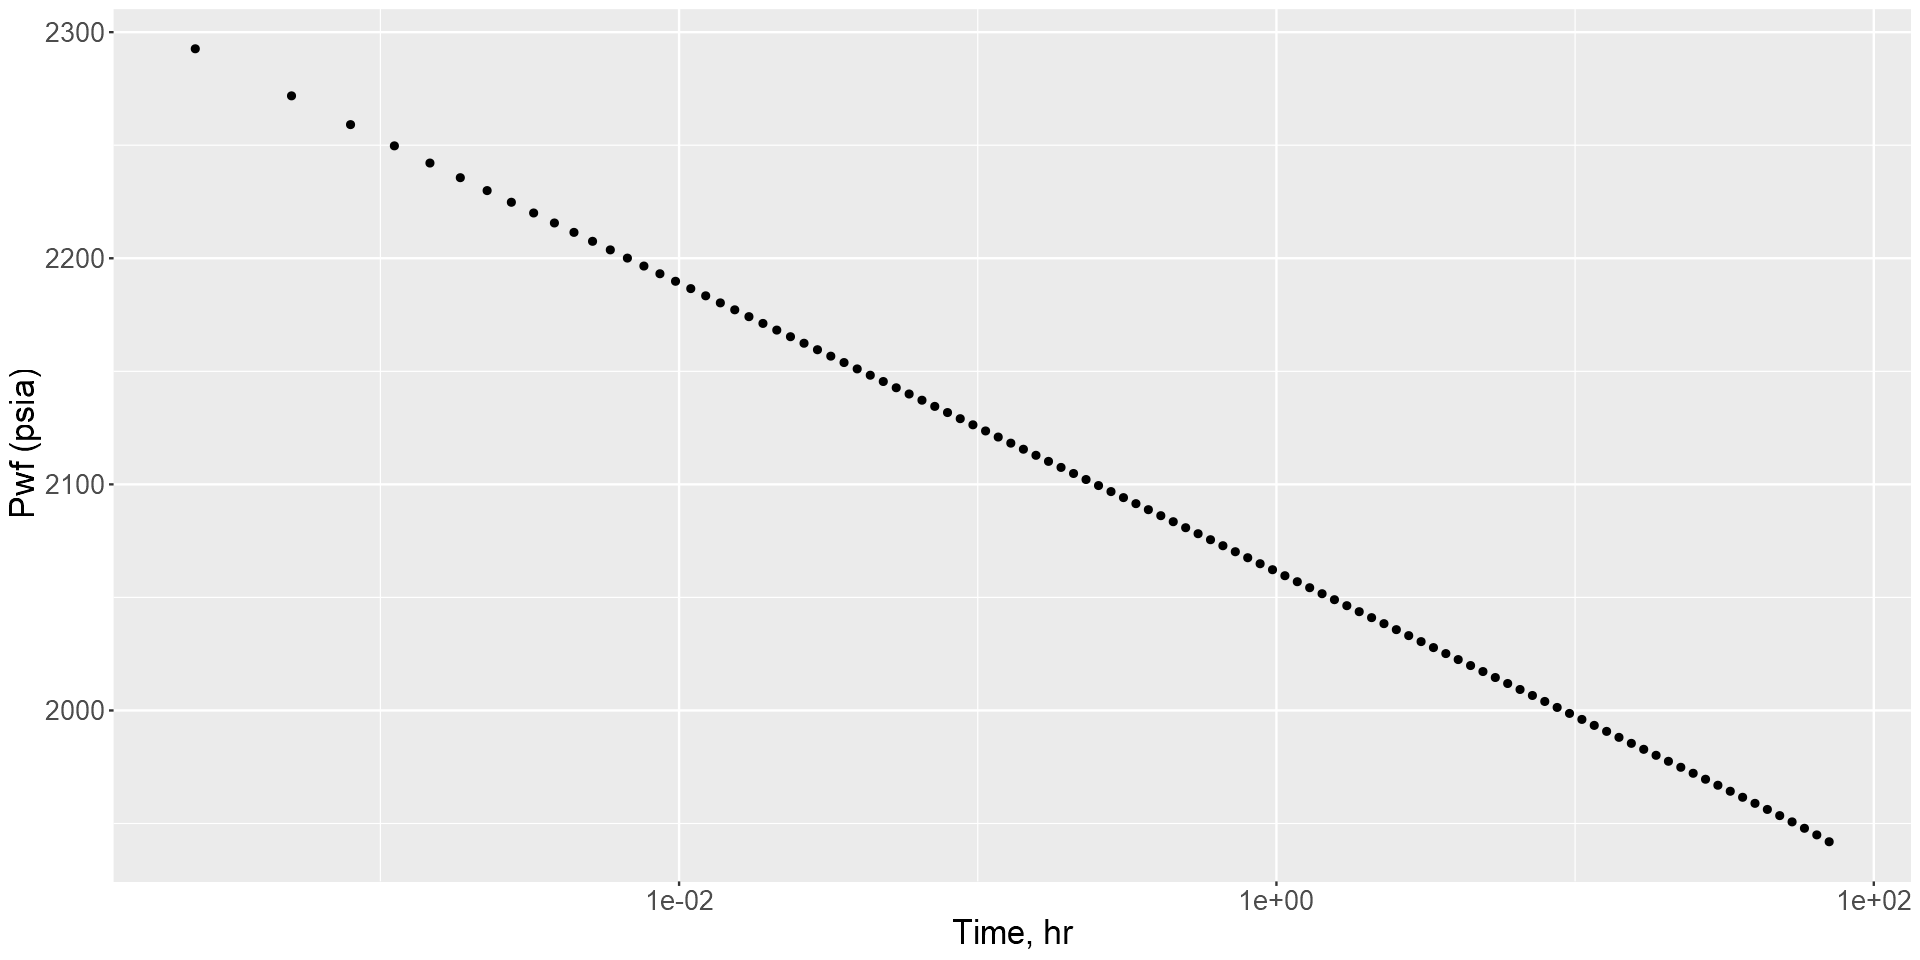

In [49]:
#Plot
#Case with out well storage, Volume multiplier = 1
options(repr.plot.width=16, repr.plot.height=8)
colnames(results_pwf) <-c("Time", "Pwf")
results_pwf$Time <- results_pwf$Time*24
ggplot(results_pwf, aes(Time, Pwf)) + 
  geom_point() +
  scale_x_log10() +
  xlab("Time, hr") + ylab("Pwf (psia)") + 
  theme(text = element_text(size=20))

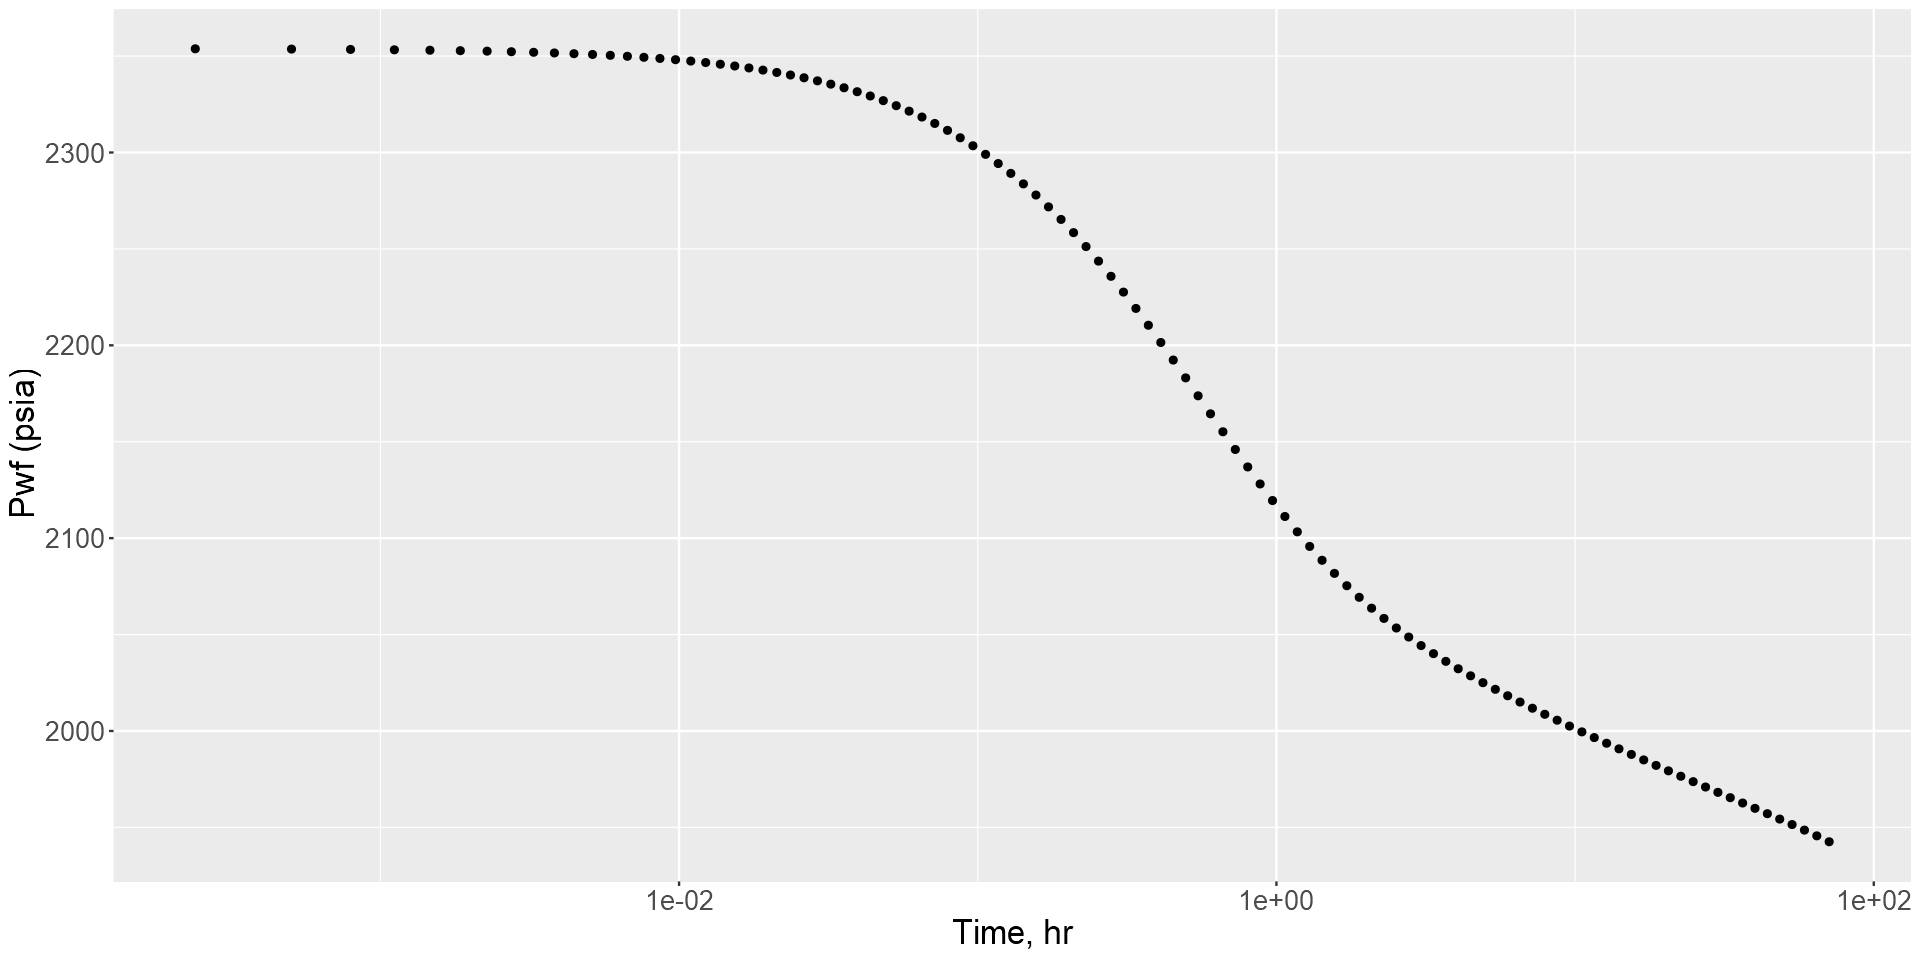

In [54]:
#Plot
#Case with well storage, Volume multiplier = 10000 
options(repr.plot.width=16, repr.plot.height=8)
colnames(results_pwf) <-c("Time", "Pwf")
results_pwf$Time <- results_pwf$Time*24
ggplot(results_pwf, aes(Time, Pwf)) + 
  geom_point() +
  scale_x_log10() +
  xlab("Time, hr") + ylab("Pwf (psia)") + 
  theme(text = element_text(size=20))